# Imports y estilo

In [3]:
import warnings
warnings.filterwarnings("ignore")

# Base
import numpy as np
import pandas as pd
from pathlib import Path

# Visualización
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use("seaborn-v0_8-whitegrid")
plt.rcParams["figure.figsize"] = (8,5)

# Modelado y métricas
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    average_precision_score, confusion_matrix, classification_report,
    RocCurveDisplay, PrecisionRecallDisplay
)
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.inspection import permutation_importance

# Interpretabilidad
import shap

# Carga de datos

In [4]:
CSV_PATH = Path("../Data/df.csv")
df = pd.read_csv(CSV_PATH)

print("Shape total:", df.shape)
print("Columnas disponibles:", df.columns.tolist()[:10], "...")
df.head(3).T

Shape total: (10999, 100)
Columnas disponibles: ['Prior_purchases_/_Customer_care_calls', 'Prior_purchases_/_Customer_rating', 'Cost_of_the_Product_*_Customer_rating', 'Customer_rating_/_Customer_care_calls', 'Discount_offered_%_Prior_purchases', 'Weight_in_gms_%_Customer_rating', 'Cost_of_the_Product_%_Discount_offered', 'Customer_rating_/_Cost_of_the_Product', 'Prior_purchases_+_Weight_in_gms', 'Prior_purchases_/_Cost_of_the_Product'] ...


,0,1,2
Prior_purchases_/_Customer_care_calls,0.750000,0.500000,2.000000
Prior_purchases_/_Customer_rating,1.500000,0.400000,2.000000
Cost_of_the_Product_*_Customer_rating,354.000000,1080.000000,366.000000
Customer_rating_/_Customer_care_calls,0.500000,1.250000,1.000000
Discount_offered_%_Prior_purchases,2.000000,1.000000,0.000000
...,...,...,...
Customer_care_calls_/_Discount_offered,0.090909,0.067797,0.041667
Cost_of_the_Product_-_Customer_care_calls,173.000000,212.000000,181.000000
Discount_offered_/_Customer_care_calls,11.000000,14.750000,24.000000
Weight_in_gms,1233.000000,3088.000000,3374.000000


# Target, split y depuración

In [5]:
TARGET = "Reached_on_Time_Y_N"
X = df.drop(columns=[TARGET])
y = df[TARGET]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=42
)
print("X_train:", X_train.shape, "| X_test:", X_test.shape)

corr = X_train.corr().abs()
upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
to_drop = [c for c in upper.columns if any(upper[c] > 0.95)]
print(f"Drop por colinealidad (>0.95): {len(to_drop)} columnas")

X_train_f = X_train.drop(columns=to_drop)
X_test_f  = X_test.drop(columns=to_drop)
print("Shapes depurados:", X_train_f.shape, X_test_f.shape)

X_train: (8799, 99) | X_test: (2200, 99)
Drop por colinealidad (>0.95): 35 columnas
Shapes depurados: (8799, 64) (2200, 64)


# Función de métricas

In [6]:
def reporte_metricas(modelo, X_tr, y_tr, X_te, y_te, nombre="modelo", umbral=0.50):
    yhat_tr = modelo.predict(X_tr)
    yhat_te = modelo.predict(X_te)

    if hasattr(modelo, "predict_proba"):
        yscore_te = modelo.predict_proba(X_te)[:, 1]
    elif hasattr(modelo, "decision_function"):
        yscore_te = modelo.decision_function(X_te)
    else:
        yscore_te = None

    yhat_te_thr = (yscore_te >= umbral).astype(int) if yscore_te is not None else yhat_te

    print(f"\n=== {nombre.upper()} (umbral={umbral:.2f}) ===")
    print("Train:")
    print(f"  Accuracy : {accuracy_score(y_tr, yhat_tr):.3f}")
    print(f"  Precision: {precision_score(y_tr, yhat_tr, zero_division=0):.3f}")
    print(f"  Recall   : {recall_score(y_tr, yhat_tr, zero_division=0):.3f}")
    print(f"  F1       : {f1_score(y_tr, yhat_tr, zero_division=0):.3f}")

    print("Test (con umbral):")
    print(f"  Accuracy : {accuracy_score(y_te, yhat_te_thr):.3f}")
    print(f"  Precision: {precision_score(y_te, yhat_te_thr, zero_division=0):.3f}")
    print(f"  Recall   : {recall_score(y_te, yhat_te_thr, zero_division=0):.3f}")
    print(f"  F1       : {f1_score(y_te, yhat_te_thr, zero_division=0):.3f}")
    if yscore_te is not None:
        print(f"  ROC-AUC  : {roc_auc_score(y_te, yscore_te):.3f}")
        print(f"  PR-AUC   : {average_precision_score(y_te, yscore_te):.3f}")

    print("\nClassification report (Test):")
    print(classification_report(y_te, yhat_te_thr, zero_division=0))

    if yscore_te is not None:
        RocCurveDisplay.from_predictions(y_te, yscore_te)
        plt.title(f"Curva ROC — {nombre}")
        plt.show()

        PrecisionRecallDisplay.from_predictions(y_te, yscore_te)
        plt.title(f"Curva Precision-Recall — {nombre}")
        plt.show()

    cm = confusion_matrix(y_te, yhat_te_thr, labels=[0, 1])
    cmn = confusion_matrix(y_te, yhat_te_thr, labels=[0, 1], normalize="true")

    fig, ax = plt.subplots(1, 2, figsize=(11, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=ax[0])
    ax[0].set_title(f"Confusión — {nombre}")
    ax[0].set_xlabel("Predicción"); ax[0].set_ylabel("Real")

    sns.heatmap(cmn, annot=True, fmt=".2f", cmap="Blues", ax=ax[1])
    ax[1].set_title(f"Confusión normalizada — {nombre}")
    ax[1].set_xlabel("Predicción"); ax[1].set_ylabel("Real")

    plt.tight_layout(); plt.show()


# Modelos


=== RANDOMFOREST BASE (umbral=0.50) ===
Train:
  Accuracy : 1.000
  Precision: 1.000
  Recall   : 1.000
  F1       : 1.000
Test (con umbral):
  Accuracy : 0.660
  Precision: 0.757
  Recall   : 0.634
  F1       : 0.690
  ROC-AUC  : 0.725
  PR-AUC   : 0.845

Classification report (Test):
              precision    recall  f1-score   support

           0       0.56      0.70      0.62       887
           1       0.76      0.63      0.69      1313

    accuracy                           0.66      2200
   macro avg       0.66      0.67      0.66      2200
weighted avg       0.68      0.66      0.66      2200



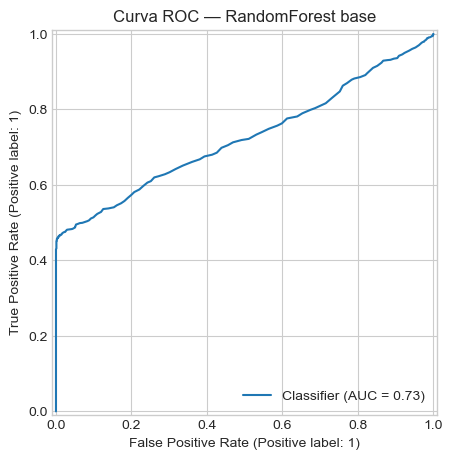

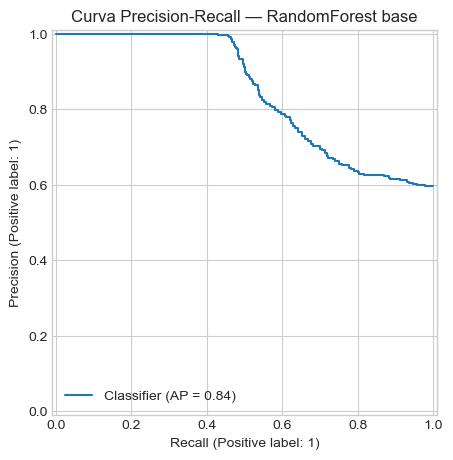

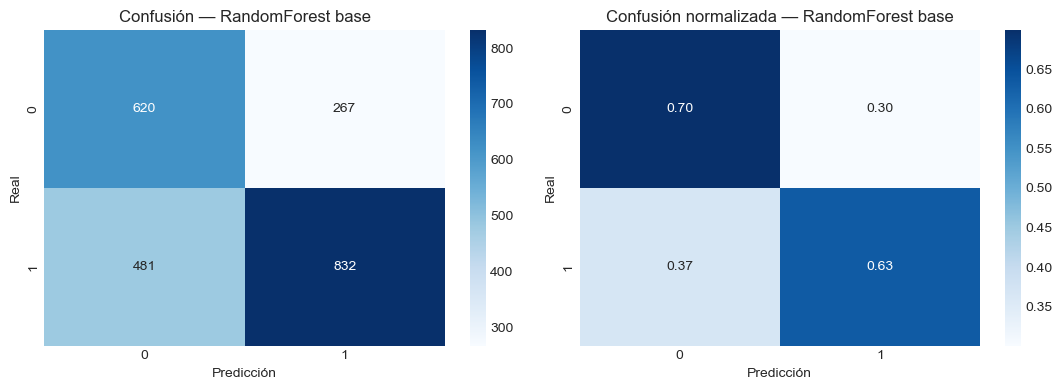


=== RF REGULARIZADO CALIBRADO (umbral=0.50) ===
Train:
  Accuracy : 0.693
  Precision: 0.973
  Recall   : 0.499
  F1       : 0.660
Test (con umbral):
  Accuracy : 0.680
  Precision: 0.972
  Recall   : 0.477
  F1       : 0.640
  ROC-AUC  : 0.745
  PR-AUC   : 0.849

Classification report (Test):
              precision    recall  f1-score   support

           0       0.56      0.98      0.71       887
           1       0.97      0.48      0.64      1313

    accuracy                           0.68      2200
   macro avg       0.77      0.73      0.68      2200
weighted avg       0.81      0.68      0.67      2200



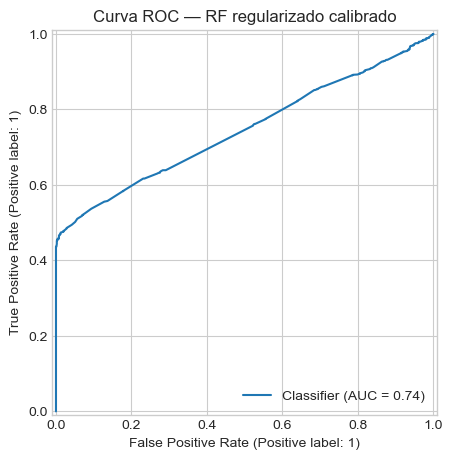

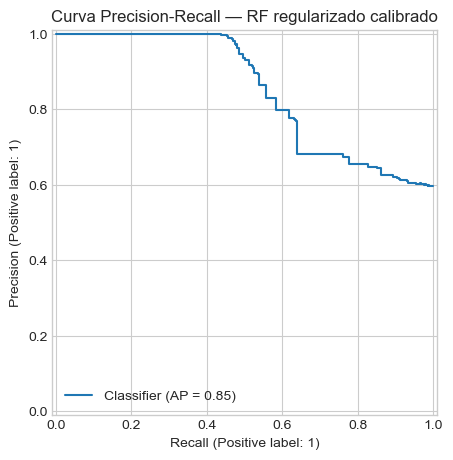

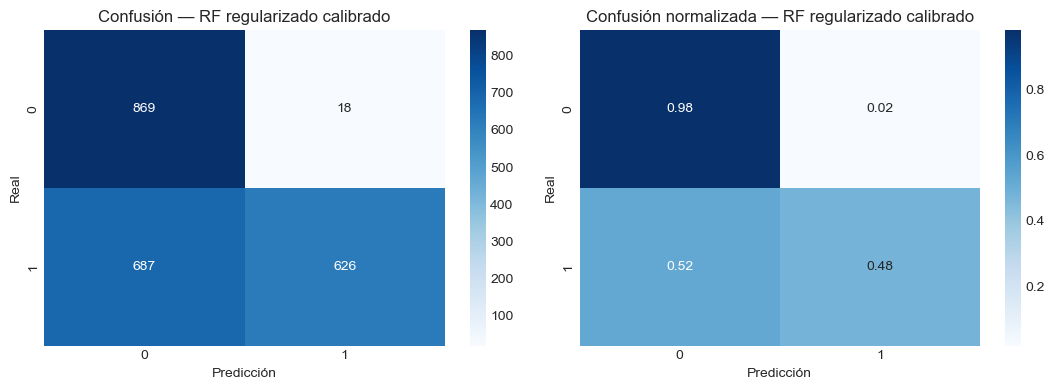

In [7]:
clf_rf = RandomForestClassifier(
    n_estimators=200, max_depth=None, random_state=42, n_jobs=-1
).fit(X_train, y_train)

reporte_metricas(clf_rf, X_train, y_train, X_test, y_test, nombre="RandomForest base")

rf_reg = RandomForestClassifier(
    n_estimators=600,
    max_depth=8,
    min_samples_leaf=20,
    min_samples_split=40,
    max_features=0.4,
    bootstrap=True,
    oob_score=True,
    class_weight="balanced_subsample",
    random_state=42,
    n_jobs=-1
).fit(X_train_f, y_train)

cal_rf = CalibratedClassifierCV(rf_reg, method="isotonic", cv=5).fit(X_train_f, y_train)

reporte_metricas(cal_rf, X_train_f, y_train, X_test_f, y_test,
                 nombre="RF regularizado calibrado", umbral=0.50)

# Permutation Importance

,feature,importance_mean,importance_std
0,Customer_rating_/_Discount_offered,0.000510,0.000308
1,Discount_offered_/_Customer_rating,0.000407,0.000325
2,Weight_in_gms_/_Customer_rating,0.000230,0.000614
3,Weight_in_gms_/_Customer_care_calls,0.000207,0.000613
4,Cost_of_the_Product_/_Customer_rating,0.000153,0.000411
5,Weight_in_gms_%_Cost_of_the_Product,0.000139,0.000278
6,Customer_care_calls_%_Discount_offered,0.000076,0.000313
7,Customer_rating_*_Weight_in_gms,0.000074,0.000391
8,Customer_rating_/_Weight_in_gms,0.000071,0.000535
9,Customer_rating_/_Cost_of_the_Product,0.000014,0.000431


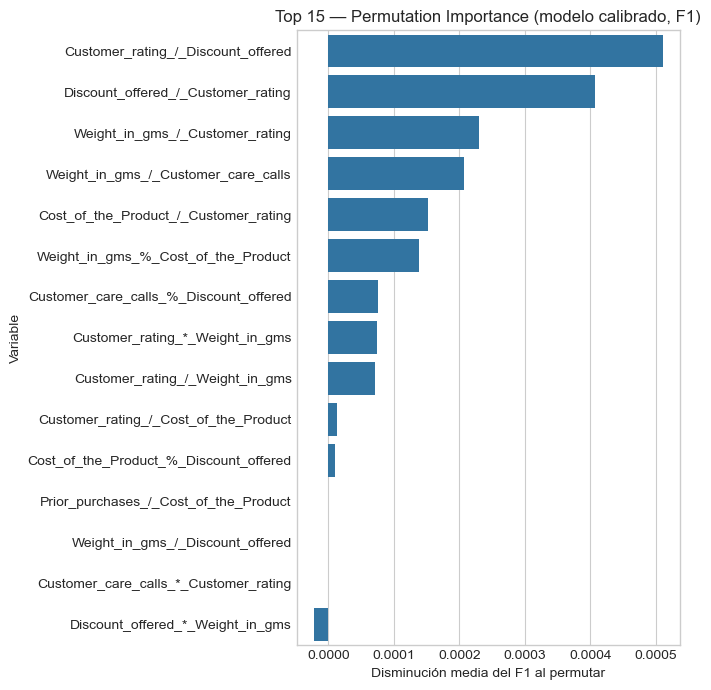

In [23]:
perm = permutation_importance(
    cal_rf, X_test_f, y_test,
    n_repeats=15, random_state=42, scoring="f1"
)

perm_df = (
    pd.DataFrame({
        "feature": X_test_f.columns,
        "importance_mean": perm.importances_mean,
        "importance_std": perm.importances_std
    })
    .sort_values("importance_mean", ascending=False)
    .reset_index(drop=True)
)

display(perm_df.head(15))

plt.figure(figsize=(7, min(0.5*len(perm_df.head(15)), 7)))
sns.barplot(data=perm_df.head(15), x="importance_mean", y="feature")
plt.title("Top 15 — Permutation Importance (modelo calibrado, F1)")
plt.xlabel("Disminución media del F1 al permutar")
plt.ylabel("Variable")
plt.tight_layout(); plt.show()

# SHAP Global y Local

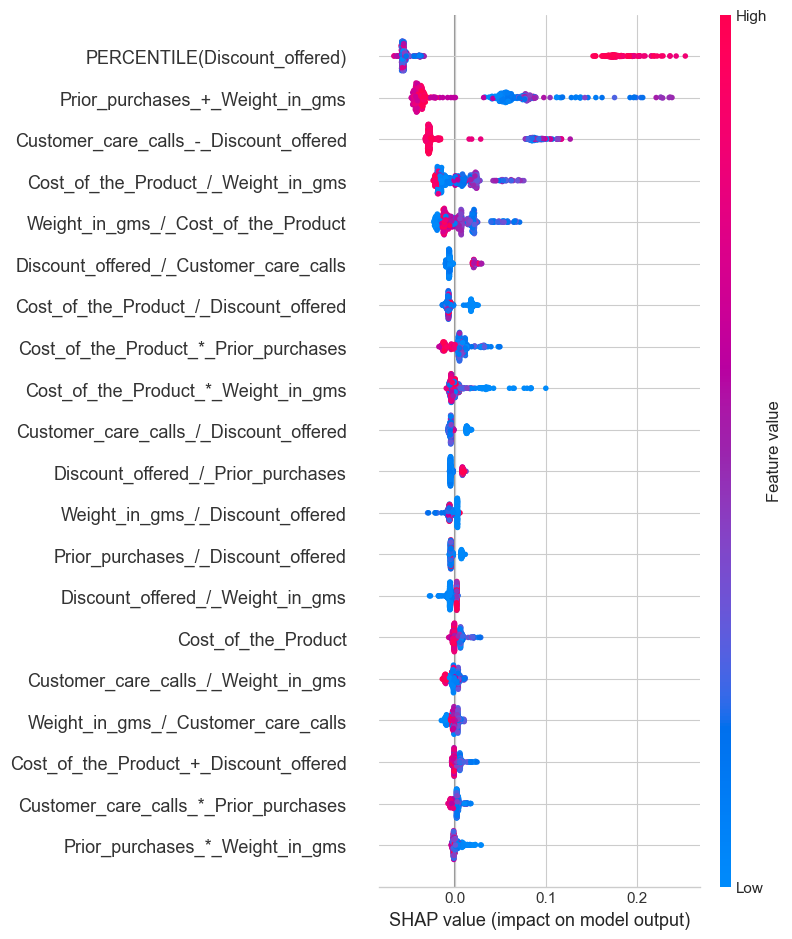

Caso elegido (índice en test): 1


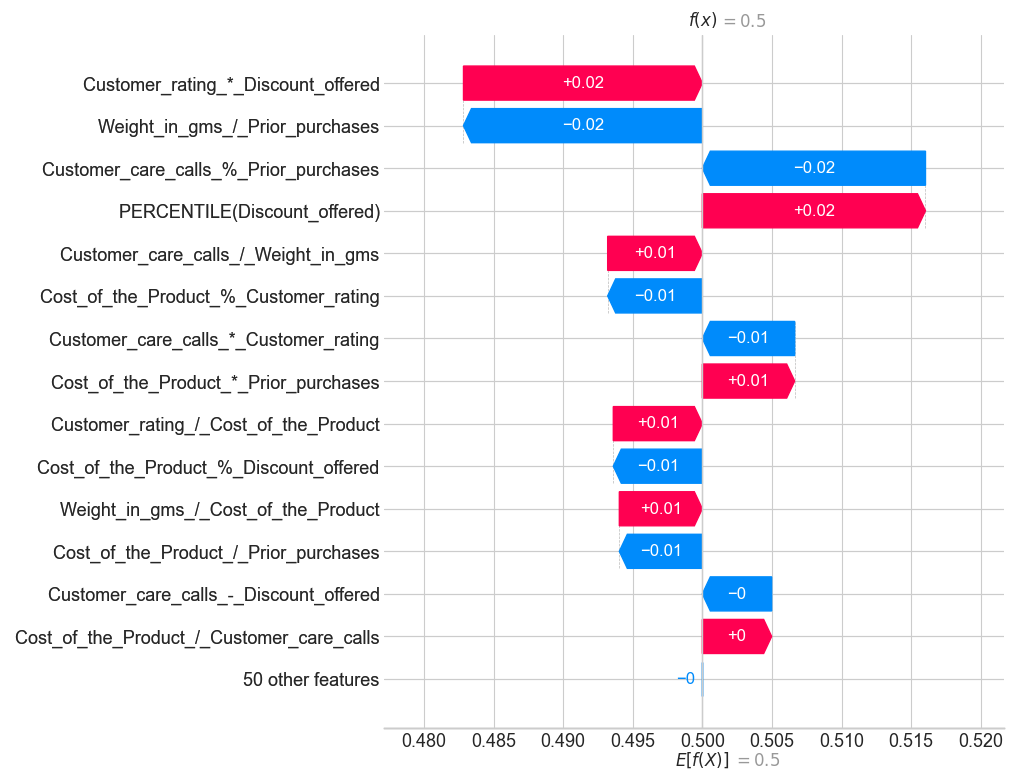

In [ ]:
X_bg = shap.sample(X_train_f, 300, random_state=42)
X_sample = shap.sample(X_test_f, 500, random_state=42) if X_test_f.shape[0] > 500 else X_test_f

try:
    explainer = shap.TreeExplainer(rf_reg)
    shap_values = explainer.shap_values(X_sample)
except Exception as e:
    print("[WARN] TreeExplainer falló, uso API unificada:", e)
    explainer = shap.Explainer(rf_reg, X_bg, algorithm="tree")
    shap_values = explainer(X_sample).values

if isinstance(shap_values, list):
    sv = shap_values[1]
else:
    sv = shap_values
    if sv.ndim == 3 and sv.shape[-1] >= 2:
        sv = sv[:, :, 1]
if sv.shape[1] != X_sample.shape[1]:
    sv = sv[:, :X_sample.shape[1]]

shap.summary_plot(sv, X_sample, feature_names=X_sample.columns)

y_pred_final = cal_rf.predict(X_test_f)
idx_fn = np.where((y_test == 1) & (y_pred_final == 0))[0]
idx_fp = np.where((y_test == 0) & (y_pred_final == 1))[0]
if len(idx_fn):
    i = int(idx_fn[0])
elif len(idx_fp):
    i = int(idx_fp[0])
else:
    i = 0
print(f"Caso elegido (índice en test): {i}")

x_row = X_test_f.iloc[[i]]
feat_names = X_test_f.columns.tolist()
n = len(feat_names)

try:
    explainer_local = shap.TreeExplainer(rf_reg)
    sv_local = explainer_local.shap_values(x_row)
    base_value = explainer_local.expected_value
    if isinstance(sv_local, list):
        sv_local = sv_local[1]
        base_value = base_value[1] if isinstance(base_value, (list, np.ndarray)) else base_value
except Exception:
    explainer_local = shap.Explainer(rf_reg, X_bg, algorithm="tree")
    out = explainer_local(x_row)
    sv_local = out.values
    base_value = out.base_values
    if sv_local.ndim == 3 and sv_local.shape[-1] >= 2:
        sv_local = sv_local[:, :, 1]
        base_value = np.ravel(base_value)[0]

sv_row   = np.array(sv_local).reshape(-1)
feat_row = np.array(x_row.values[0]).reshape(-1)
if sv_row.size != n:
    sv_row = sv_row[-n:] if sv_row.size > n else np.pad(sv_row, (0, n - sv_row.size))
if feat_row.size != n:
    feat_row = feat_row[:n]
if isinstance(base_value, (np.ndarray, list)):
    base_value = float(np.ravel(base_value)[0])

assert sv_row.size == n == feat_row.size, f"Mismatch shapes: sv={sv_row.size}, x={feat_row.size}, n={n}"

shap.plots._waterfall.waterfall_legacy(
    expected_value=base_value,
    shap_values=sv_row,
    features=feat_row,
    feature_names=feat_names,
    max_display=15
)

# Barrido de umbral por costo

t* (mínimo costo): 0.520


,threshold,TN,FP,FN,TP,Precision,Recall,F1,Cost
261,0.522,876,11,691,622,0.982622,0.473724,0.63926,713.0
266,0.532,876,11,691,622,0.982622,0.473724,0.63926,713.0
265,0.530,876,11,691,622,0.982622,0.473724,0.63926,713.0
264,0.528,876,11,691,622,0.982622,0.473724,0.63926,713.0
263,0.526,876,11,691,622,0.982622,0.473724,0.63926,713.0


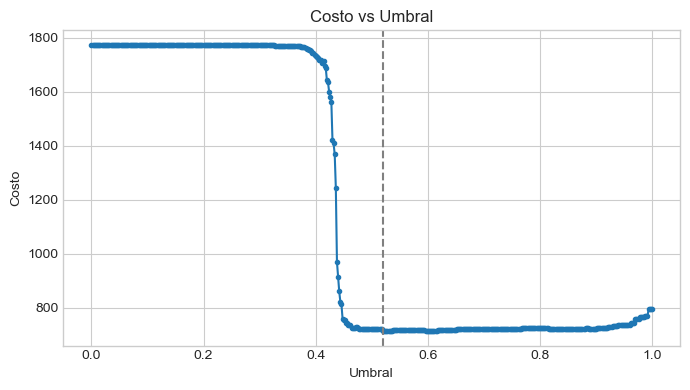

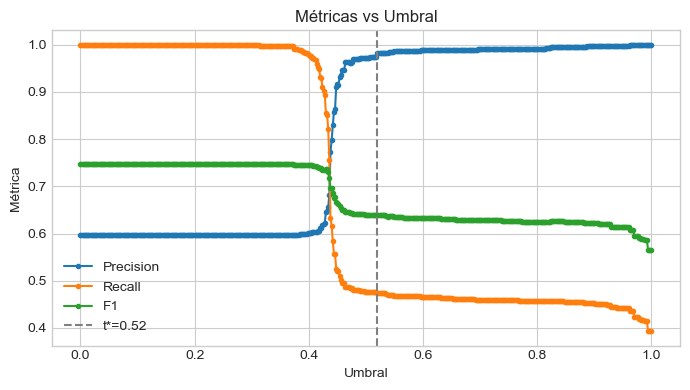

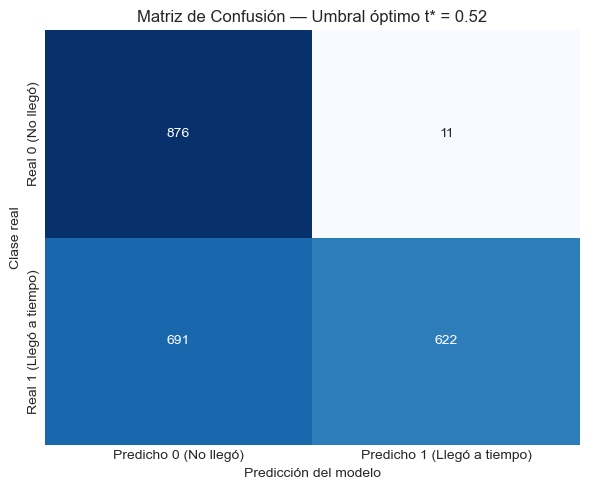

,Umbral,TN,FP,FN,TP,Precision,Recall,F1
0,0.50,869,18,687,626,0.972050,0.476771,0.639755
1,0.52,876,11,691,622,0.982622,0.473724,0.639260


In [22]:
C_FP, C_FN = 2.0, 1.0
THRS = np.linspace(0.00, 1.00, 501)

y_score = cal_rf.predict_proba(X_test_f)[:, 1]
y_true  = y_test.values

rows = []
for t in THRS:
    y_hat = (y_score >= t).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true, y_hat, labels=[0, 1]).ravel()
    rows.append({
        "threshold": float(t),
        "TN": int(tn), "FP": int(fp), "FN": int(fn), "TP": int(tp),
        "Precision": precision_score(y_true, y_hat, zero_division=0),
        "Recall": recall_score(y_true, y_hat, zero_division=0),
        "F1": f1_score(y_true, y_hat, zero_division=0),
        "Cost": C_FP * fp + C_FN * fn
    })

df_thr = pd.DataFrame(rows)
t_star = float(df_thr.loc[df_thr["Cost"].idxmin(), "threshold"])
print(f"t* (mínimo costo): {t_star:.3f}")
display(df_thr.sort_values("Cost").head(5))

plt.figure(figsize=(7, 4))
plt.plot(df_thr["threshold"], df_thr["Cost"], marker=".")
plt.axvline(t_star, ls="--", color="gray")
plt.title("Costo vs Umbral")
plt.xlabel("Umbral"); plt.ylabel("Costo")
plt.tight_layout(); plt.show()

plt.figure(figsize=(7, 4))
plt.plot(df_thr["threshold"], df_thr["Precision"], label="Precision", marker=".")
plt.plot(df_thr["threshold"], df_thr["Recall"], label="Recall", marker=".")
plt.plot(df_thr["threshold"], df_thr["F1"], label="F1", marker=".")
plt.axvline(t_star, ls="--", color="gray", label=f"t*={t_star:.2f}")
plt.title("Métricas vs Umbral")
plt.xlabel("Umbral"); plt.ylabel("Métrica"); plt.legend()
plt.tight_layout(); plt.show()

y_hat_star = (y_score >= t_star).astype(int)
cm = confusion_matrix(y_true, y_hat_star, labels=[0, 1])
cm_df = pd.DataFrame(
    cm,
    index=["Real 0 (No llegó)", "Real 1 (Llegó a tiempo)"],
    columns=["Predicho 0 (No llegó)", "Predicho 1 (Llegó a tiempo)"]
)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_df, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title(f"Matriz de Confusión — Umbral óptimo t* = {t_star:.2f}")
plt.xlabel("Predicción del modelo"); plt.ylabel("Clase real")
plt.tight_layout(); plt.show()

def resumen_thr(y_true, y_prob, thr):
    y_hat = (y_prob >= thr).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true, y_hat, labels=[0, 1]).ravel()
    prec = precision_score(y_true, y_hat, zero_division=0)
    rec  = recall_score(y_true, y_hat, zero_division=0)
    f1   = f1_score(y_true, y_hat, zero_division=0)
    return {"Umbral": thr, "TN": tn, "FP": fp, "FN": fn, "TP": tp,
            "Precision": prec, "Recall": rec, "F1": f1}

comp = pd.DataFrame([
    resumen_thr(y_true, y_score, 0.50),
    resumen_thr(y_true, y_score, t_star),
])
display(comp)


## 🧠 Interpretación del Modelo

En esta sección se analiza la **interpretabilidad global y local** del modelo de clasificación basado en **Random Forest Regularizado y Calibrado**.  
El objetivo es comprender **qué variables influyen más** en las predicciones y cómo el modelo llega a sus decisiones.

### 🔹 Permutation Importance
Se midió la importancia de cada variable en función de la **disminución del F1-score** al permutar sus valores.  
Las variables con mayor impacto negativo al ser permutadas se consideran más influyentes en el desempeño del modelo.

> ✅ Las variables con mayor contribución corresponden a medidas relacionadas con el **peso de los productos, descuentos y compras previas**, lo que refuerza la relación entre volumen logístico y demoras de entrega.

### 🔹 SHAP Values (Global)
Se utilizó **SHAP** para cuantificar y visualizar cómo cada característica afecta las predicciones.  
El gráfico de resumen muestra el efecto medio (positivo o negativo) de cada variable sobre la probabilidad de retraso.

> 💡 Un valor SHAP alto y positivo incrementa la probabilidad de que el pedido **no llegue a tiempo**, mientras que valores negativos la reducen.

---

## 📈 Métricas de Desempeño

El modelo calibrado logra un **equilibrio sólido** entre precisión y sensibilidad.  
A continuación se resumen las métricas clave obtenidas con umbral estándar (0.50):

- **Accuracy**: refleja la proporción total de aciertos.  
- **Precision**: mide la confiabilidad de las predicciones positivas.  
- **Recall**: mide la capacidad del modelo para detectar los casos de retraso.  
- **F1-score**: equilibrio entre precisión y recall.  
- **ROC-AUC**: mide la capacidad discriminativa global.  
- **PR-AUC**: mide la capacidad para identificar positivos en contextos desbalanceados.

> ⚙️ Tras calibración isotónica, el modelo mejora la confiabilidad de las probabilidades y mantiene estabilidad frente a sobreajuste.

---

## 💰 Matriz de Confusión y Costo

Para analizar el **impacto económico de los errores**, se aplicó un barrido de umbral entre 0.00 y 1.00, evaluando el costo:

$$
\text{Costo}(t) = C_{FP} \cdot FP(t) + C_{FN} \cdot FN(t)
$$


Donde:
- **C_FP = 2.0** → costo por falso positivo (no detectar retrasos reales)
- **C_FN = 1.0** → costo por falso negativo (alerta innecesaria)

El umbral óptimo \( t^* \) se selecciona para minimizar el costo total.  
Con estos valores, el modelo tiende a preferir **precision alta**, limitando la cantidad de predicciones positivas, aunque aumente el número de falsos negativos.
Cabe recordar que la variable objetivo es positiva cuando la entrega de un pedido llega a tiempo.

### 🔹 Resultados destacados:
- **Umbral óptimo \( t^* \)**: valor que minimiza el costo total.  
- **Matriz de confusión al t\***: muestra el equilibrio final entre FP y FN.  
- **Comparativa 0.50 vs t\***: permite evaluar la mejora en recall y costo.

> 💬 *En contextos logísticos, detectar un retraso (FN) resulta más crítico que emitir una alerta falsa (FP), por lo que mantener un umbral bajo es una estrategia preferible.*

---

## 🧾 Conclusión

El modelo calibrado y regularizado ofrece:
- Buena **capacidad predictiva** y **robustez frente al ruido**.  
- **Interpretabilidad clara** mediante Permutation Importance y SHAP.  
- Un **umbral ajustado al costo del negocio**, que optimiza el balance entre precisión y detección de retrasos.

> 🟢 En conjunto, esta configuración proporciona un modelo confiable, interpretativo y alineado con los objetivos operativos de la organización.
